<a href="https://colab.research.google.com/github/Azarbaad/Data_analytics/blob/main/sql_brazilian_ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Olist Brazilian E-Commerce SQL Analysis



In [7]:
# Install kaggle if needed
!pip install kaggle

# Upload your kaggle.json API key (download from Kaggle account settings)
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d olistbr/brazilian-ecommerce
!unzip brazilian-ecommerce.zip

Saving brazilian-ecommerce.zip to brazilian-ecommerce.zip
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
Archive:  brazilian-ecommerce.zip
  inflating: olist_customers_dataset.csv  
  inflating: olist_ge

In [8]:
# Step 2: Import libraries and enable interactive data tables
import sqlite3
import pandas as pd
import os

from google.colab import data_table  # This is the key import
from google.colab.data_table import DataTable

# Enable interactive tables for ALL pandas DataFrames displayed later
data_table.enable_dataframe_formatter()

# Optional: Limit max rows/columns for performance (adjust as needed)
DataTable.max_columns = 50
DataTable.max_rows = 10000

In [9]:
# Step 3: Load CSVs into SQLite database
conn = sqlite3.connect('olist.db')

csv_files = [f for f in os.listdir('.') if f.startswith('olist_') and f.endswith('.csv')]

for csv in csv_files:
    df = pd.read_csv(csv)
    table_name = csv.replace('.csv', '').replace('olist_', '')
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    print(f"Loaded {csv} → table '{table_name}' ({len(df)} rows)")

# List all tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("\nTables in database:")
display(tables)  # This will now be interactive!

Loaded olist_order_reviews_dataset.csv → table 'order_reviews_dataset' (99224 rows)
Loaded olist_order_payments_dataset.csv → table 'order_payments_dataset' (103886 rows)
Loaded olist_products_dataset.csv → table 'products_dataset' (32951 rows)
Loaded olist_orders_dataset.csv → table 'orders_dataset' (99441 rows)
Loaded olist_sellers_dataset.csv → table 'sellers_dataset' (3095 rows)
Loaded olist_geolocation_dataset.csv → table 'geolocation_dataset' (1000163 rows)
Loaded olist_customers_dataset.csv → table 'customers_dataset' (99441 rows)
Loaded olist_order_items_dataset.csv → table 'order_items_dataset' (112650 rows)

Tables in database:


,name
0,order_reviews_dataset
1,order_payments_dataset
2,products_dataset
3,orders_dataset
4,sellers_dataset
5,geolocation_dataset
6,customers_dataset
7,order_items_dataset


In [10]:
# Step 4: Quick interactive preview of each table (first 20 rows)
for table in tables['name']:
    print(f"\n--- Preview: {table} ---")
    preview = pd.read_sql(f"SELECT * FROM {table} LIMIT 10;", conn)
    display(DataTable(preview))  # Explicit interactive table – sortable/searchable!


--- Preview: order_reviews_dataset ---


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,None,None,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,None,None,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,None,None,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,None,None,2017-05-17 00:00:00,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47



--- Preview: order_payments_dataset ---


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
5,298fcdf1f73eb413e4d26d01b25bc1cd,1,credit_card,2,96.12
6,771ee386b001f06208a7419e4fc1bbd7,1,credit_card,1,81.16
7,3d7239c394a212faae122962df514ac7,1,credit_card,3,51.84
8,1f78449c87a54faf9e96e88ba1491fa9,1,credit_card,6,341.09
9,0573b5e23cbd798006520e1d5b4c6714,1,boleto,1,51.95



--- Preview: products_dataset ---


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
5,41d3672d4792049fa1779bb35283ed13,instrumentos_musicais,60.0,745.0,1.0,200.0,38.0,5.0,11.0
6,732bd381ad09e530fe0a5f457d81becb,cool_stuff,56.0,1272.0,4.0,18350.0,70.0,24.0,44.0
7,2548af3e6e77a690cf3eb6368e9ab61e,moveis_decoracao,56.0,184.0,2.0,900.0,40.0,8.0,40.0
8,37cc742be07708b53a98702e77a21a02,eletrodomesticos,57.0,163.0,1.0,400.0,27.0,13.0,17.0
9,8c92109888e8cdf9d66dc7e463025574,brinquedos,36.0,1156.0,1.0,600.0,17.0,10.0,12.0



--- Preview: orders_dataset ---


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,None,None,2017-05-09 00:00:00
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07 00:00:00
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06 00:00:00
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23 00:00:00



--- Preview: sellers_dataset ---


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
5,c240c4061717ac1806ae6ee72be3533b,20920,rio de janeiro,RJ
6,e49c26c3edfa46d227d5121a6b6e4d37,55325,brejao,PE
7,1b938a7ec6ac5061a66a3766e0e75f90,16304,penapolis,SP
8,768a86e36ad6aae3d03ee3c6433d61df,1529,sao paulo,SP
9,ccc4bbb5f32a6ab2b7066a4130f114e3,80310,curitiba,PR



--- Preview: geolocation_dataset ---


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
5,1012,-23.547762,-46.635361,são paulo,SP
6,1047,-23.546273,-46.641225,sao paulo,SP
7,1013,-23.546923,-46.634264,sao paulo,SP
8,1029,-23.543769,-46.634278,sao paulo,SP
9,1011,-23.547640,-46.636032,sao paulo,SP



--- Preview: customers_dataset ---


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG
8,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,curitiba,PR
9,4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,belo horizonte,MG



--- Preview: order_items_dataset ---


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
5,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,21.90,12.69
6,00054e8431b9d7675808bcb819fb4a32,1,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,19.90,11.85
7,000576fe39319847cbb9d288c5617fa6,1,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,810.00,70.75
8,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65
9,0005f50442cb953dcd1d21e1fb923495,1,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,53.99,11.40


**1. How many orders are in the dataset?**

Business Question: Get a quick overview of the dataset size.

In [11]:
query = """
SELECT COUNT(*) AS total_orders
FROM orders_dataset;
"""
result = pd.read_sql(query, conn)
display(DataTable(result))  # Interactive view!

,total_orders
0,99441


**2. What is the date range of orders? (First and last order)**

Business Question: Understand the time period covered.

In [12]:
query = """
SELECT
    MIN(order_purchase_timestamp) AS first_order,
    MAX(order_purchase_timestamp) AS last_order
FROM orders_dataset;"""
result  = pd.read_sql(query, conn)
display(DataTable(result))


,first_order,last_order
0,2016-09-04 21:15:19,2018-10-17 17:30:18


**3. How many unique customers are there?**

Business Question: Measure customer base size.

In [13]:
query = """
SELECT COUNT(DISTINCT customer_unique_id) AS unique_customers
FROM customers_dataset;
"""
result = pd.read_sql(query, conn)
display(DataTable(result))

,unique_customers
0,96096


**4. What are the top 10 product categories by number of orders?**

Business Question: Identify best-selling product types.


In [14]:
query = """
SELECT
    p.product_category_name,
    COUNT(oi.order_id) AS order_count
FROM order_items_dataset oi
JOIN products_dataset p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY order_count DESC
LIMIT 10;
 """
result = pd.read_sql(query, conn)
display(DataTable(result))

,product_category_name,order_count
0,cama_mesa_banho,11115
1,beleza_saude,9670
2,esporte_lazer,8641
3,moveis_decoracao,8334
4,informatica_acessorios,7827
5,utilidades_domesticas,6964
6,relogios_presentes,5991
7,telefonia,4545
8,ferramentas_jardim,4347
9,automotivo,4235


**5. What is the total revenue generated? (Use price + freight_value)**

Business Question: Calculate overall sales performance.

In [15]:
query = """
SELECT
    Round(SUM(oi.price + oi.freight_value),2) AS total_revenue
FROM order_items_dataset oi
"""
result = pd.read_sql(query, conn)
display(DataTable(result))

,total_revenue
0,15843553.24


**6. What are the top 5 states by number of customers?**

Business Question: Identify key geographic markets.

In [16]:
query = """
SELECT customer_state,
    COUNT(*) AS customer_count
FROM customers_dataset
GROUP BY customer_state
ORDER BY customer_count DESC
LIMIT 5; """
result = pd.read_sql(query, conn)
display(DataTable(result))

,customer_state,customer_count
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045


**7. How many orders were delivered late? (Compare delivered vs estimated date)**

Business Question: Measure delivery performance.

In [ ]:
query = """
SELECT
    COUNT(*) AS late_deliveries
FROM orders_dataset
WHERE order_delivered_customer_date > order_estimated_delivery_date
  AND order_delivered_customer_date IS NOT NULL;
"""
result = pd.read_sql(query, conn)
display(DataTable(result))

,late_deliveries
0,7827


**8. What is the average review score by product category (top 10 highest rated)?**


Business Question: Find customer satisfaction per category.

In [ ]:
query = """
SELECT
    p.product_category_name,
    ROUND(AVG(r.review_score), 2) AS avg_review_score,
    COUNT(r.review_id) AS review_count
FROM order_reviews_dataset r
JOIN order_items_dataset oi ON r.order_id = oi.order_id
JOIN products_dataset p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
HAVING review_count >= 50  -- Filter for meaningful averages
ORDER BY avg_review_score DESC
LIMIT 10;
"""
result = pd.read_sql(query, conn)
display(DataTable(result))

,product_category_name,avg_review_score,review_count
0,livros_interesse_geral,4.45,549
1,construcao_ferramentas_ferramentas,4.44,99
2,livros_importados,4.40,60
3,livros_tecnicos,4.37,266
4,malas_acessorios,4.32,1088
5,alimentos_bebidas,4.32,279
6,portateis_casa_forno_e_cafe,4.30,76
7,fashion_calcados,4.23,261
8,alimentos,4.22,495
9,cine_foto,4.21,73


**9. Monthly trend of total revenue (over time)**

Business Question: See sales growth pattern.

In [ ]:
query = """
SELECT
    STRFTIME('%Y-%m', order_purchase_timestamp) AS month,
    ROUND(SUM(oi.price + oi.freight_value), 2) AS monthly_revenue
FROM orders_dataset o
JOIN order_items_dataset oi ON o.order_id = oi.order_id
WHERE o.order_status = 'delivered'
GROUP BY month
ORDER BY month;
"""
result = pd.read_sql(query, conn)
display(DataTable(result))


,month,monthly_revenue
0,2016-09,143.46
1,2016-10,46490.66
2,2016-12,19.62
3,2017-01,127482.37
4,2017-02,271239.32
5,2017-03,414330.95
6,2017-04,390812.40
7,2017-05,566851.40
8,2017-06,490050.37
9,2017-07,566299.08


**10. What are the top 5 sellers by revenue?**

Business Question: Identify top-performing sellers.

In [ ]:
query = """
SELECT
    oi.seller_id,
    ROUND(SUM(oi.price + oi.freight_value), 2) AS total_revenue
FROM order_items_dataset oi
GROUP BY oi.seller_id
ORDER BY total_revenue DESC
LIMIT 5;
"""
result = pd.read_sql(query, conn)
display(DataTable(result))

,seller_id,total_revenue
0,4869f7a5dfa277a7dca6462dcf3b52b2,249640.70
1,7c67e1448b00f6e969d365cea6b010ab,239536.44
2,53243585a1d6dc2643021fd1853d8905,235856.68
3,4a3ca9315b744ce9f8e9374361493884,235539.96
4,fa1c13f2614d7b5c4749cbc52fecda94,204084.73


# Day 2
## 1. What is the average order value (AOV)?

Business Question: Key e-commerce metric for revenue per transaction.

In [ ]:
query = """ SELECT
    ROUND(AVG(total_per_order), 2) AS avg_order_value
FROM (
    SELECT
        o.order_id,
        SUM(oi.price + oi.freight_value) AS total_per_order
    FROM orders_dataset o
    JOIN order_items_dataset oi ON o.order_id = oi.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY o.order_id
);
"""
result = pd.read_sql(query, conn)
display(DataTable(result))

,avg_order_value
0,159.83


## 2. Top 10 customers by total spend

Business Question: Identify high-value customers for loyalty programs.

In [ ]:
query = """
SELECT
    c.customer_unique_id,
    ROUND(SUM(oi.price + oi.freight_value), 2) AS total_spend
FROM customers_dataset c
JOIN orders_dataset o ON c.customer_id = o.customer_id
JOIN order_items_dataset oi ON o.order_id = oi.order_id
GROUP BY c.customer_unique_id
ORDER BY total_spend DESC
LIMIT 10;
"""
result = pd.read_sql(query, conn)
display(DataTable(result))


,customer_unique_id,total_spend
0,0a0a92112bd4c708ca5fde585afaa872,13664.08
1,da122df9eeddfedc1dc1f5349a1a690c,7571.63
2,763c8b1c9c68a0229c42c9fc6f662b93,7274.88
3,dc4802a71eae9be1dd28f5d788ceb526,6929.31
4,459bef486812aa25204be022145caa62,6922.21
5,ff4159b92c40ebe40454e3e6a7c35ed6,6726.66
6,4007669dec559734d6f53e029e360987,6081.54
7,5d0a2980b292d049061542014e8960bf,4809.44
8,eebb5dda148d3893cdaf5b5ca3040ccb,4764.34
9,48e1ac109decbb87765a3eade6854098,4681.78


## 3. Number of orders per payment type

Business Question: Understand preferred payment methods.

In [ ]:
query = """
SELECT
    op.payment_type,
    COUNT(DISTINCT op.order_id) AS order_count,
    ROUND(SUM(op.payment_value), 2) AS total_revenue
FROM order_payments_dataset op
GROUP BY op.payment_type
ORDER BY order_count DESC;
"""
result = pd.read_sql(query, conn)
display(DataTable(result))

,payment_type,order_count,total_revenue
0,credit_card,76505,12542084.19
1,boleto,19784,2869361.27
2,voucher,3866,379436.87
3,debit_card,1528,217989.79
4,not_defined,3,0.00


## 4. Average delivery time in days (actual vs estimated)

Business Question: Quantify delivery performance.

In [ ]:
query = """
SELECT
    ROUND(AVG(julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp)), 1) AS avg_actual_days,
    ROUND(AVG(julianday(order_estimated_delivery_date) - julianday(order_purchase_timestamp)), 1) AS avg_estimated_days
FROM orders_dataset
WHERE order_delivered_customer_date IS NOT NULL;
"""
result = pd.read_sql(query, conn)
display(DataTable(result))

,avg_actual_days,avg_estimated_days
0,12.6,23.7


## 5. Top 5 product categories by revenue

Business Question: Revenue leaders (vs. just order count).

In [ ]:
query = """
SELECT
    p.product_category_name,
    ROUND(SUM(oi.price + oi.freight_value), 2) AS category_revenue
FROM order_items_dataset oi
JOIN products_dataset p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY category_revenue DESC
LIMIT 5;
"""
result = pd.read_sql(query, conn)
display(DataTable(result))


,product_category_name,category_revenue
0,beleza_saude,1441248.07
1,relogios_presentes,1305541.61
2,cama_mesa_banho,1241681.72
3,esporte_lazer,1156656.48
4,informatica_acessorios,1059272.40


## 6. Sellers with the most late deliveries (top 5)

Business Question: Flag underperforming sellers.

In [17]:
query = """
WITH late_orders AS (
    SELECT
        oi.seller_id,
        COUNT(*) AS late_count
    FROM order_items_dataset oi
    JOIN orders_dataset o ON oi.order_id = o.order_id
    WHERE o.order_delivered_customer_date > o.order_estimated_delivery_date
      AND o.order_delivered_customer_date IS NOT NULL
    GROUP BY oi.seller_id
)
SELECT
    seller_id,
    late_count
FROM late_orders
ORDER BY late_count DESC
LIMIT 5;
"""
result = pd.read_sql(query, conn)
display(DataTable(result))


,seller_id,late_count
0,4a3ca9315b744ce9f8e9374361493884,214
1,1f50f920176fa81dab994f9023523100,182
2,4869f7a5dfa277a7dca6462dcf3b52b2,133
3,1025f0e2d44d7041d6cf58b6550e0bfa,131
4,7c67e1448b00f6e969d365cea6b010ab,130


## 7. Monthly growth rate of revenue (% change from previous month)

Business Question: Track business momentum.

In [18]:
query = """
WITH monthly_rev AS (
    SELECT
        STRFTIME('%Y-%m', order_purchase_timestamp) AS month,
        ROUND(SUM(oi.price + oi.freight_value), 2) AS revenue
    FROM orders_dataset o
    JOIN order_items_dataset oi ON o.order_id = oi.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY month
)
SELECT
    month,
    revenue,
    ROUND((revenue - LAG(revenue) OVER (ORDER BY month)) / LAG(revenue) OVER (ORDER BY month) * 100, 2) AS growth_pct
FROM monthly_rev
ORDER BY month;
    """
result = pd.read_sql(query, conn)
display(DataTable(result))


,month,revenue,growth_pct
0,2016-09,143.46,NaN
1,2016-10,46490.66,32306.71
2,2016-12,19.62,-99.96
3,2017-01,127482.37,649657.24
4,2017-02,271239.32,112.77
5,2017-03,414330.95,52.75
6,2017-04,390812.40,-5.68
7,2017-05,566851.40,45.04
8,2017-06,490050.37,-13.55
9,2017-07,566299.08,15.56


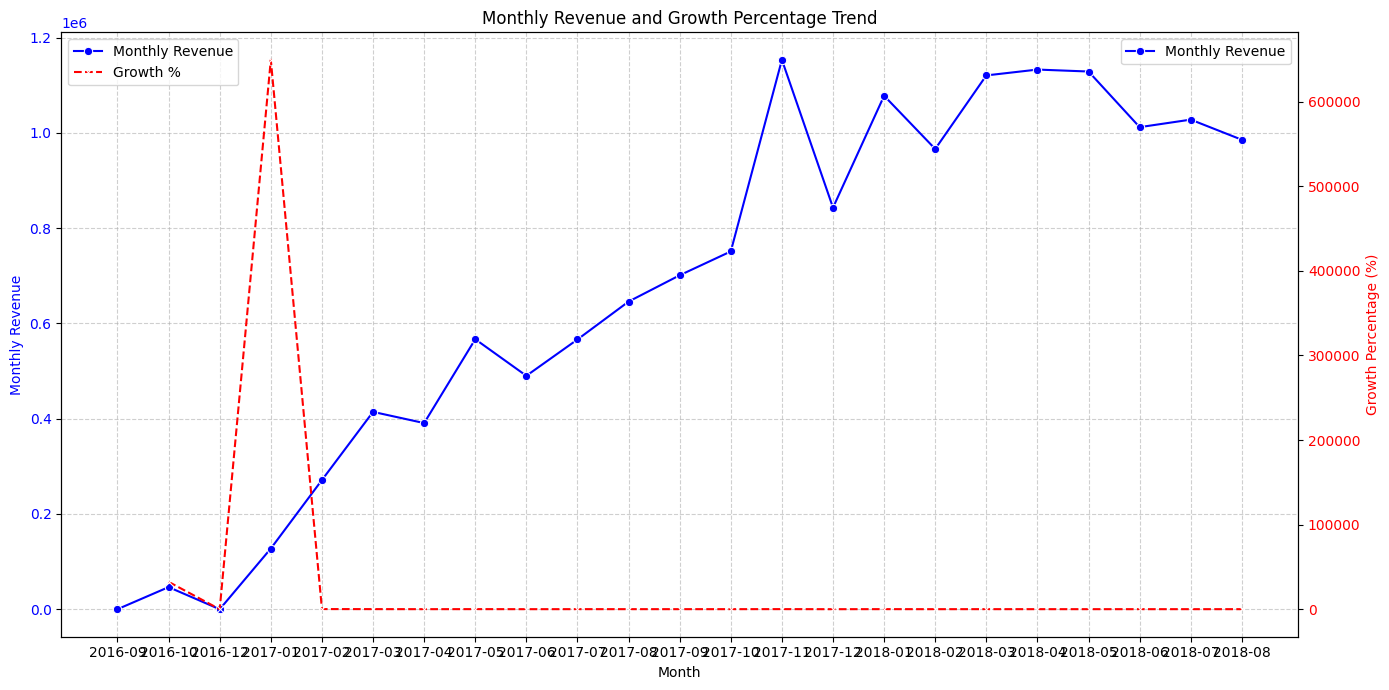

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot monthly revenue on the primary y-axis
sns.lineplot(x='month', y='revenue', data=result, ax=ax1, color='blue', marker='o', label='Monthly Revenue')
ax1.set_xlabel('Month')
ax1.set_ylabel('Monthly Revenue', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for growth percentage
ax2 = ax1.twinx()
sns.lineplot(x='month', y='growth_pct', data=result, ax=ax2, color='red', marker='x', linestyle='--', label='Growth %')
ax2.set_ylabel('Growth Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and grid
plt.title('Monthly Revenue and Growth Percentage Trend')
ax1.grid(True, linestyle='--', alpha=0.6)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a legend for both lines
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

The high fluctuations in the initial months, especially the extremely large growth percentages, are primarily due to the small base effect. When the starting revenue is very low, even a small increase in absolute terms can lead to a massive percentage growth.

To show the underlying trend more clearly and reduce the impact of these extreme fluctuations (which you've termed 'out layer' or outliers), we can consider a few approaches:

##Focus on later periods:

If the early data is highly volatile and not representative of the business's typical operations, we could choose to analyze growth only from a certain point onwards when the business has matured.

##Smoothing Techniques:
###Moving Average (Rolling Mean):

 This is a common technique where each data point is replaced by the average of the data points within a defined window (e.g., a 3-month or 6-month moving average). This helps to smooth out short-term fluctuations and highlight longer-term trends.
###Exponential Smoothing:

More advanced methods like exponential smoothing give more weight to recent observations.
##Outlier Detection and Treatment:

 You could statistically identify extreme outliers and either remove them (if they are genuine errors) or cap them (replace them with a less extreme value) before plotting.

### Focusing on the Late Period (from July 2017 onwards)

In [24]:
# Filter the result DataFrame to focus on data from '2017-07' onwards
result_late_period = result[result['month'] >= '2017-07'].copy()

# Recalculate the 3-month rolling average for growth percentage on the filtered data
# Reset index first to ensure rolling window works correctly on sequential data
result_late_period['growth_pct_rolling_avg'] = result_late_period['growth_pct'].rolling(window=3, min_periods=1).mean()

# Recalculate the deviation of the original growth from the rolling average for the filtered data
result_late_period['growth_deviation_from_avg'] = result_late_period['growth_pct'] - result_late_period['growth_pct_rolling_avg']

# Display the updated result_late_period DataFrame
display(DataTable(result_late_period))

,month,revenue,growth_pct,growth_pct_rolling_avg,growth_deviation_from_avg
9,2017-07,566299.08,15.56,15.560000,0.000000
10,2017-08,645832.36,14.04,14.800000,-0.760000
11,2017-09,701077.49,8.55,12.716667,-4.166667
12,2017-10,751117.01,7.14,9.910000,-2.770000
13,2017-11,1153364.20,53.55,23.080000,30.470000
14,2017-12,843078.29,-26.90,11.263333,-38.163333
15,2018-01,1077887.46,27.85,18.166667,9.683333
16,2018-02,966168.41,-10.36,-3.136667,-7.223333
17,2018-03,1120598.24,15.98,11.156667,4.823333
18,2018-04,1132878.93,1.10,2.240000,-1.140000


Now, let's re-plot the monthly revenue growth, the rolling average, and the deviation for this focused late period.

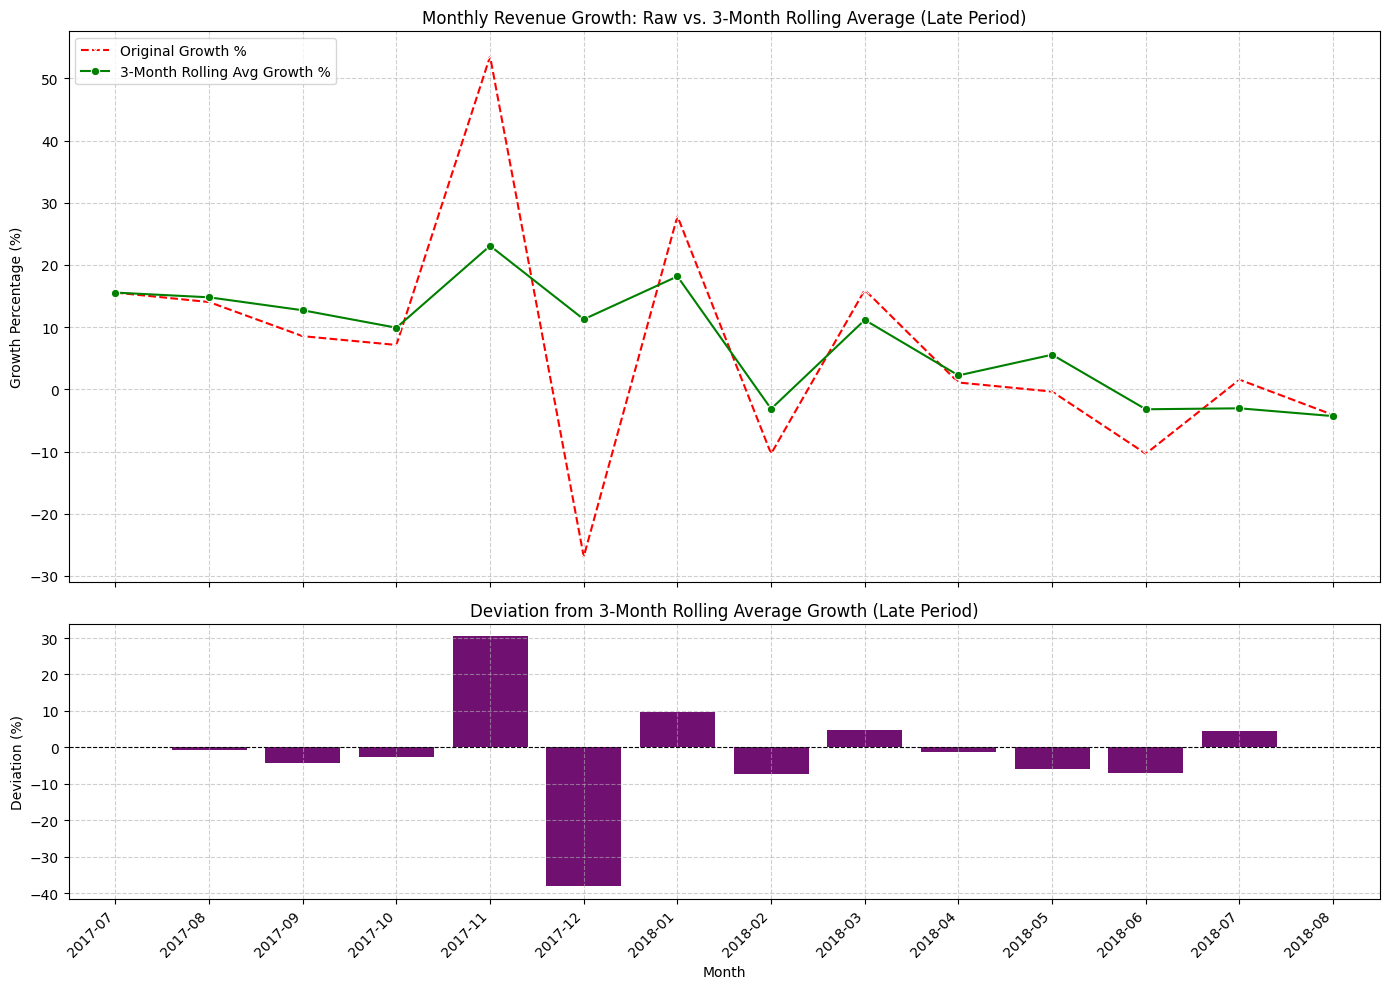

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots, sharing the x-axis
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# --- Top Subplot: Original Growth vs. Rolling Average (Late Period) ---
sns.lineplot(x='month', y='growth_pct', data=result_late_period, ax=axes[0], color='red', marker='x', linestyle='--', label='Original Growth %')
sns.lineplot(x='month', y='growth_pct_rolling_avg', data=result_late_period, ax=axes[0], color='green', marker='o', linestyle='-', label='3-Month Rolling Avg Growth %')

axes[0].set_title('Monthly Revenue Growth: Raw vs. 3-Month Rolling Average (Late Period)')
axes[0].set_ylabel('Growth Percentage (%)')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend(loc='upper left')

# --- Bottom Subplot: Deviation from Rolling Average (Late Period) ---
sns.barplot(x='month', y='growth_deviation_from_avg', data=result_late_period, ax=axes[1], color='purple')
axes[1].axhline(0, color='black', linestyle='--', linewidth=0.8) # Add a zero line

axes[1].set_title('Deviation from 3-Month Rolling Average Growth (Late Period)')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Deviation (%)')
axes[1].grid(True, linestyle='--', alpha=0.6)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 8. Rank product categories by average review score (with rank)

Business Question: Best-rated categories using window function.

In [26]:
query = """
SELECT
    product_category_name,
    avg_review_score,
    RANK() OVER (ORDER BY avg_review_score DESC) AS rank
FROM (
    SELECT
        p.product_category_name,
        ROUND(AVG(r.review_score), 2) AS avg_review_score,
        COUNT(*) AS review_count
    FROM order_reviews_dataset r
    JOIN order_items_dataset oi ON r.order_id = oi.order_id
    JOIN products_dataset p ON oi.product_id = p.product_id
    GROUP BY p.product_category_name
    HAVING review_count >= 100
);
"""
result = pd.read_sql(query, conn)
display(DataTable(result))

,product_category_name,avg_review_score,rank
0,livros_interesse_geral,4.45,1
1,livros_tecnicos,4.37,2
2,alimentos_bebidas,4.32,3
3,malas_acessorios,4.32,3
4,fashion_calcados,4.23,5
5,alimentos,4.22,6
6,papelaria,4.19,7
7,pet_shop,4.19,7
8,pcs,4.18,9
9,eletrodomesticos,4.17,10


## 9. Orders with multiple items (count and %)

Business Question: Measure average items per order.

In [27]:
query = """
WITH items_per_order AS (
    SELECT
        order_id,
        COUNT(*) AS item_count
    FROM order_items_dataset
    GROUP BY order_id
)
SELECT
    SUM(CASE WHEN item_count > 1 THEN 1 ELSE 0 END) AS multi_item_orders,
    COUNT(*) AS total_orders,
    ROUND(100.0 * SUM(CASE WHEN item_count > 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS multi_item_pct
FROM items_per_order;
"""
result = pd.read_sql(query, conn)
display(DataTable(result))

,multi_item_orders,total_orders,multi_item_pct
0,9803,98666,9.94


multi_item_orders (9803):

This number represents the total count of orders that contained more than one item. This indicates orders where customers purchased multiple different products or multiple units of the same product within a single transaction.

total_orders (98666):

This is the total number of unique orders in the dataset that had at least one item. It serves as the base for calculating the percentage.

multi_item_pct (9.94):

 This is the percentage of total orders that contained multiple items. It is calculated as (multi_item_orders / total_orders) * 100. So, approximately 9.94% of all orders placed by customers included more than one product.

 ## Insight


 while the majority of orders (around 90%) are for single items, nearly 10% of orders are for multiple items.

## 10. Geolocation: Top 5 cities by order count

Business Question: Pinpoint urban hotspots.

In [28]:
query = """
SELECT
    customer_city,
    COUNT(*) AS order_count
FROM customers_dataset
GROUP BY customer_city
ORDER BY order_count DESC
LIMIT 5;
"""
result = pd.read_sql(query, conn)
display(DataTable(result))


,customer_city,order_count
0,sao paulo,15540
1,rio de janeiro,6882
2,belo horizonte,2773
3,brasilia,2131
4,curitiba,1521
